Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 共发现 8 个CSV文件，正在加载 ...


📖 读取CSV: 100%|██████████| 8/8 [00:02<00:00,  2.78it/s]


✅ 合并后数据集大小: (2830743, 79)
🔎 类别分布 (英文名/数量)：
BENIGN                    : 2273097
DoS Hulk                  : 231073
PortScan                  : 158930
DDoS                      : 128027
DoS GoldenEye             : 10293
FTP-Patator               : 7938
SSH-Patator               : 5897
DoS slowloris             : 5796
DoS Slowhttptest          : 5499
Bot                       : 1966
Web Attack – Brute Force  : 1507
Web Attack – XSS          : 652
Infiltration              : 36
Web Attack – Sql Injection : 21
Heartbleed                : 11

🧩 正在分割训练集和测试集 ...
训练集: 2264595   测试集: 566148

🚀 正在训练模型 ...
[2025-07-18 17:35:15.692] [CUML] [warning] L-BFGS stopped, because the line search failed to advance (step delta = 0.000000)
✅ 模型训练完毕!

🔮 正在测试集评估 ...
🎯 Test Accuracy (测试集准确率): 0.9765

📊 绘制混淆矩阵 ...


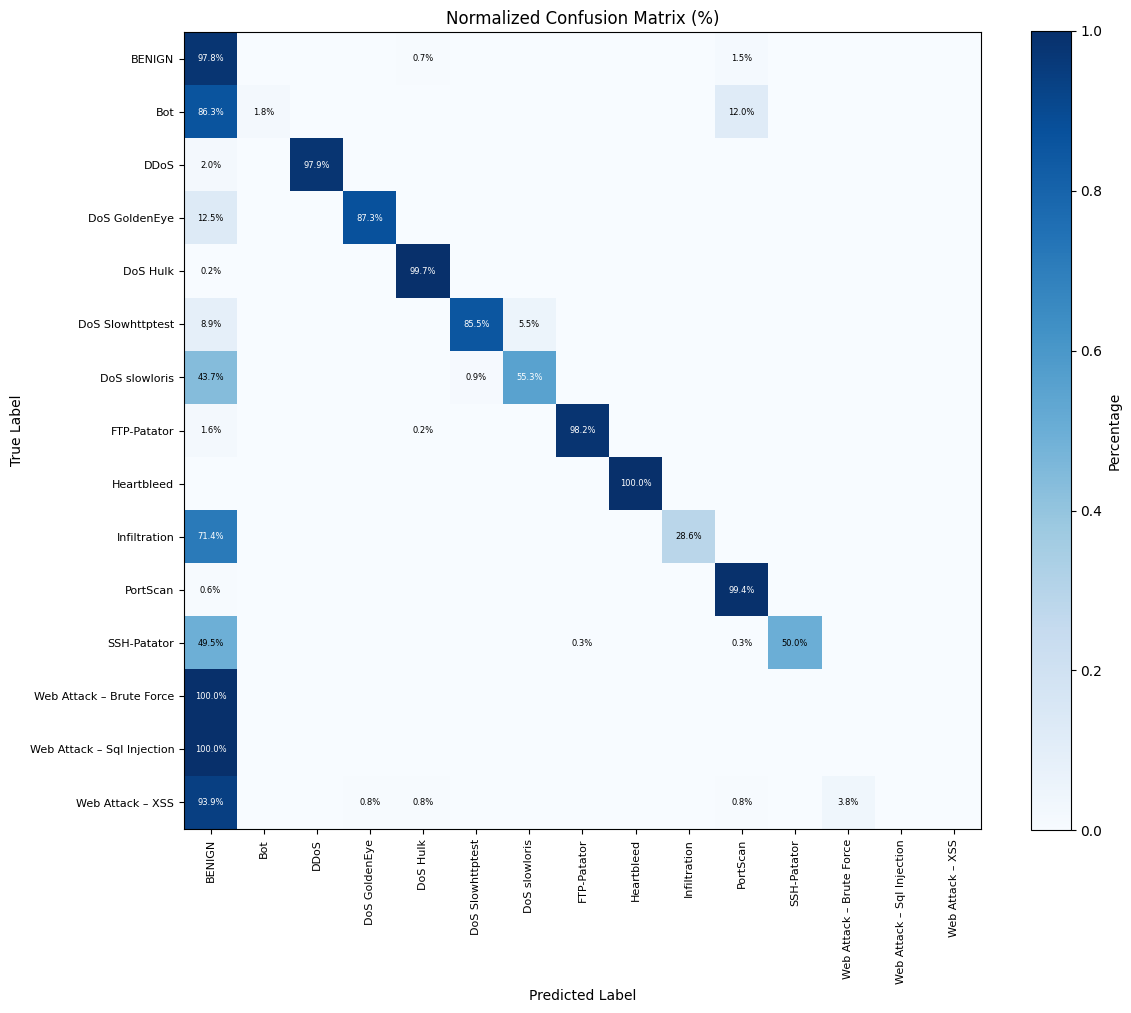


📈 Drawing micro‑averaged PR curve ...


/tmp/ipython-input-1-1512101306.py:186: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(DATA_DIR/"valilla_pr_curve.png", dpi=300)


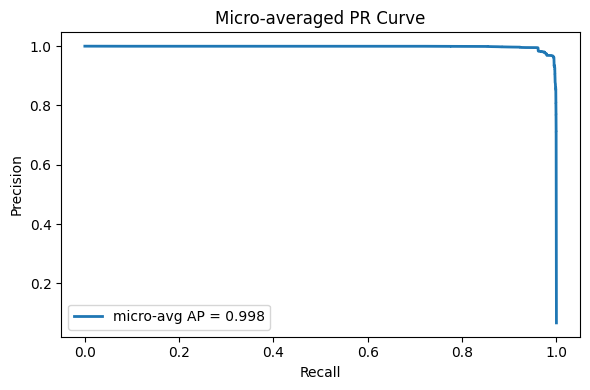

📊 Per‑class precision/recall ...


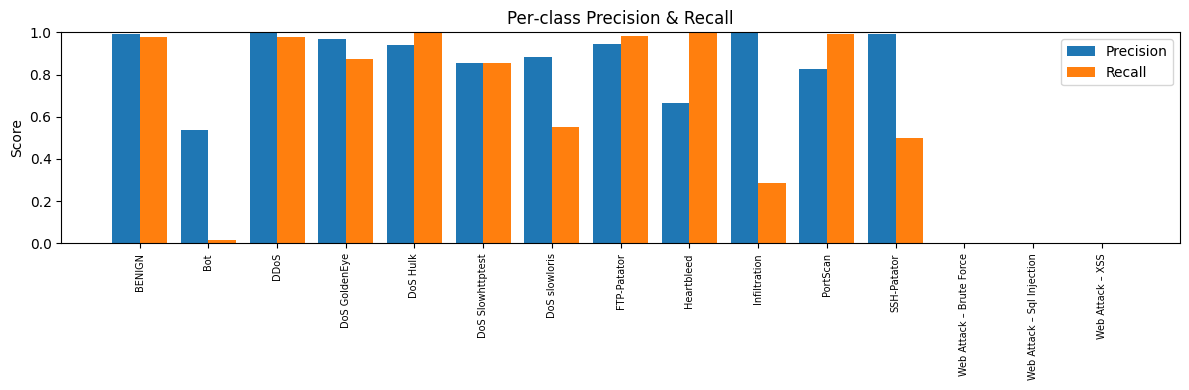

🔍 Top‑20 feature importance ...


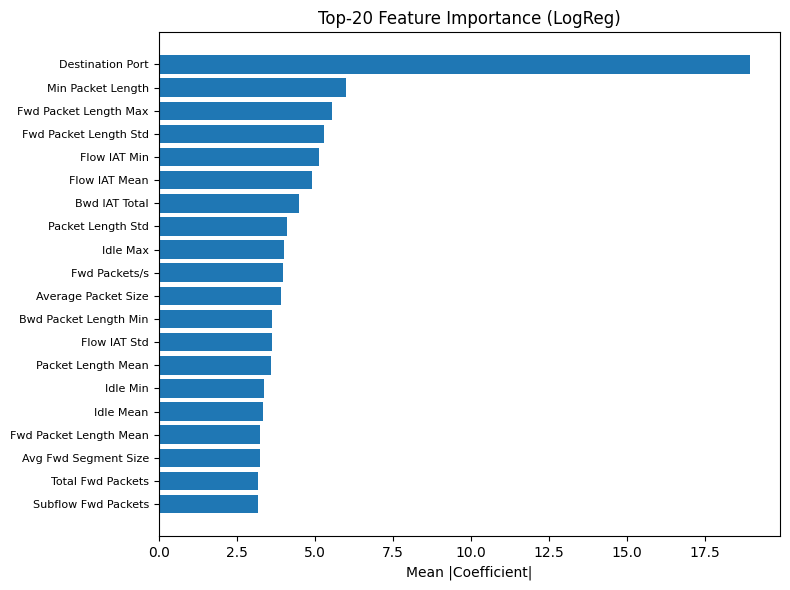

In [1]:
# ========= Vanilla Logistic Regression (No Downsampling, No Class Weights) =========

# 挂载 Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')

from pathlib import Path

# cudf, cupy, cuml: RAPIDS GPU 加速库
import cudf
import cupy as cp
import unicodedata
from cuml.model_selection import train_test_split
from cuml.preprocessing import StandardScaler
from cuml.linear_model import LogisticRegression
from cuml.metrics import accuracy_score, confusion_matrix

# tqdm显示进度条
from tqdm import tqdm

# pandas, numpy: 数据处理（部分只用于辅助或转换）
import pandas as pd
import numpy as np

# matplotlib绘图
import matplotlib.pyplot as plt

# ========= 指定数据集文件位置 =========
DATA_DIR = Path("/content/drive/My Drive/Colab Notebooks/MachineLearningCVE")

# ========= 1. 读取 & 合并 , 读取所有8个.csv 文件并合并成一个大表格df=========
# 使用 cudf.read_csv() 以 GPU 加速读取
csv_files = sorted(DATA_DIR.glob("*.csv"))
print(f"📂 共发现 {len(csv_files)} 个CSV文件，正在加载 ...")
dfs = [cudf.read_csv(str(f)) for f in tqdm(csv_files, desc="📖 读取CSV")]
df = cudf.concat(dfs, ignore_index=True)
print(f"✅ 合并后数据集大小: {df.shape}")

# ========= 2. 清洗无关列: 去除列名空格;删除无用信息列（如 IP、时间戳）=========
df.columns = df.columns.str.strip()
drop_cols = [c for c in df.columns if c.lower() in ["flow id", "source ip", "destination ip", "timestamp"]]
df = df.drop(columns=drop_cols, errors="ignore")

# ========= 3. 标签处理 =========
# 自动查找 Label 列（避免名字大小写/空格问题）
# 清洗标签字符串，转换为标准格式
# 将标签转成 GPU 上的 cudf Series（用于后续训练）
def clean_label(label):
    if not isinstance(label, (str, int, float, type(None))):
        return "UNKNOWN"
    if pd.isna(label):
        return "UNKNOWN"
    label = str(label)
    return unicodedata.normalize("NFKD", label).replace("–", "-").replace("—", "-").strip()

# 自动找到Label列名（防止空格/大小写/奇葩命名）
label_col = [c for c in df.columns if c.strip().lower() == "label"][0]
y_raw = df.pop(label_col).to_pandas().apply(clean_label)
y_raw = cudf.Series(y_raw)

# 全部数据转换为 float32; 替换空值、无穷值为 0
X = df.astype("float32").fillna(0).replace([cp.inf, -cp.inf], 0)

# ========= 4. 标签编码 & 分布 : 将攻击类型映射为整数编码（便于分类器使用）=========
#attack_types = y_raw.unique().to_pandas().tolist()
# 替换乱码标签
y_raw = y_raw.str.replace('Web Attack � Brute Force', 'Web Attack – Brute Force')
y_raw = y_raw.str.replace('Web Attack � XSS', 'Web Attack – XSS')
y_raw = y_raw.str.replace('Web Attack � Sql Injection', 'Web Attack – Sql Injection')

# 获取所有唯一标签
attack_types = y_raw.unique().to_pandas().tolist()

# 建立名称到索引的映射（按名字排序）
attack_to_idx = {name: idx for idx, name in enumerate(sorted(attack_types))}

idx_to_attack = {v: k for k, v in attack_to_idx.items()}
y = y_raw.map(attack_to_idx).astype("int32")

label_en_cnt = pd.Series(y_raw.to_pandas()).value_counts().sort_values(ascending=False)
print("🔎 类别分布 (英文名/数量)：")
for name, cnt in label_en_cnt.items():
    print(f"{name:25s} : {cnt}")

# ========= 5. 保留原始分布 (不再下采样) =========
# 直接使用完整数据集进行训练与评估
X_full = X
y_full = y

# ========= 6. 训练集/测试集划分（分层） : 保持各类攻击在训练/测试集中的比例一致=========
print("\n🧩 正在分割训练集和测试集 ...")
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=42
)
print(f"训练集: {len(y_train)}   测试集: {len(y_test)}")

# ========= 7. 取消类别加权 =========
# 不计算权重，直接训练

# ========= 8. 标准化: 使用 StandardScaler 将特征标准化，有助于模型收敛=========
# with_mean=False 是因为稀疏矩阵不支持减均值
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ========= 9. 训练逻辑回归模型 =========
#模型类型：GPU 加速的逻辑回归
#惩罚项：L2 正则化
#solver: "qn" 表示拟牛顿方法（适合大规模数据）
print("\n🚀 正在训练模型 ...")
logreg = LogisticRegression(max_iter=1500, C=0.8, penalty="l2", solver="qn")
logreg.fit(X_train_scaled, y_train)  # 不再传入 sample_weight
print("✅ 模型训练完毕!")

# ========= 10. 评估 =========
# 使用测试集进行预测
# 计算预测准确率
print("\n🔮 正在测试集评估 ...")
y_pred = logreg.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"🎯 Test Accuracy (测试集准确率): {acc:.4f}")

# ========= 11. 混淆矩阵 （归一化） =========
# 计算每个类别的预测正确率和错误率
# 显示为百分比矩阵，直观展示模型对每类攻击的识别效果

print("\n📊 绘制混淆矩阵 ...")
cm = confusion_matrix(y_test, y_pred).get()
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)
classes = [idx_to_attack[i] for i in range(len(idx_to_attack))]
plt.figure(figsize=(12, 10))
plt.imshow(cm_norm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix (%)")
plt.colorbar(label="Percentage")
plt.xticks(np.arange(len(classes)), classes, rotation=90, fontsize=8)
plt.yticks(np.arange(len(classes)), classes, fontsize=8)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
thresh = cm_norm.max() / 2.
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        if val > 0.001:
            plt.text(j, i, f"{val*100:.1f}%", ha='center', va='center',
                     color="white" if val > thresh else "black", fontsize=6)
plt.tight_layout()
plt.savefig(DATA_DIR/"confusion_matrix.png", dpi=300)
plt.show()

#总结
#这份代码的目标是：
#基于 CIC-IDS-2017 数据集
#构建一个基础逻辑回归分类器
#保留真实攻击类别分布（未进行下采样）
#使用 GPU 加速的 cuDF 和 cuML
#最终通过 准确率 + 混淆矩阵 评估模型表现

# ========= 9. Micro‑averaged PR curve =========
print("\n📈 Drawing micro‑averaged PR curve ...")
num_classes = len(idx_to_attack)

# convert y_test & proba to CPU numpy
y_test_cpu = y_test.to_pandas().values
y_pred_proba_df = logreg.predict_proba(X_test_scaled)  # cuDF DataFrame

# DataFrame -> NumPy
y_scores = y_pred_proba_df.to_pandas().values

# Binarize labels
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

Y_test_bin = label_binarize(y_test_cpu, classes=list(range(num_classes)))

precision, recall, _ = precision_recall_curve(Y_test_bin.ravel(), y_scores.ravel())
avp = average_precision_score(Y_test_bin, y_scores, average="micro")

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, lw=2, label=f"micro‑avg AP = {avp:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Micro‑averaged PR Curve")
plt.legend()
plt.tight_layout()
plt.savefig(DATA_DIR/"valilla_pr_curve.png", dpi=300)
plt.show()

# ========= 10. Per‑class Precision & Recall bars =========
print("📊 Per‑class precision/recall ...")

# Get class names
classes = [idx_to_attack[i] for i in range(len(idx_to_attack))]

from sklearn.metrics import precision_recall_fscore_support
prec, rec, _, _ = precision_recall_fscore_support(
    y_test_cpu, y_pred.to_pandas().values, zero_division=0
)
ind = np.arange(num_classes)
width = 0.4
plt.figure(figsize=(12, 4))
plt.bar(ind - width/2, prec, width, label="Precision")
plt.bar(ind + width/2, rec,  width, label="Recall")
plt.xticks(ind, classes, rotation=90, fontsize=7)
plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Per‑class Precision & Recall")
plt.legend()
plt.tight_layout()
plt.savefig(DATA_DIR/"valilla_per_class_pr.png", dpi=300)
plt.show()


# ========= 11. Feature Importance (Top‑20) =========
print("🔍 Top‑20 feature importance ...")
coef_attr = logreg.coef_
# cuML 24.x: coef_ may be CuPy ndarray (with .get), or cuDF DataFrame
if hasattr(coef_attr, "get"):
    coef_cpu = coef_attr.get()
elif hasattr(coef_attr, "to_pandas"):
    coef_cpu = coef_attr.to_pandas().values
else:
    coef_cpu = np.asarray(coef_attr)

abs_coef = np.abs(coef_cpu).mean(axis=0)
TOP_K = 20
top_idx = np.argsort(abs_coef)[-TOP_K:][::-1]
feat_names = list(X.columns)

plt.figure(figsize=(8, 6))
plt.barh(range(TOP_K), abs_coef[top_idx][::-1])
plt.yticks(range(TOP_K), [feat_names[i] for i in top_idx][::-1], fontsize=8)
plt.xlabel("Mean |Coefficient|")
plt.title("Top‑20 Feature Importance (LogReg)")
plt.tight_layout()
plt.savefig(DATA_DIR/"valilla_feature_importance.png", dpi=300)
plt.show()